# Homework 4: Coding

**Due Monday October 7th, 11:59pm.**

**This is an individual assignment.**

**There is no autograder submission, please add your responses and graphs to your LaTeX submission as indicated in the assignment.**

In [0]:
"""
Import libraries that you might require
"""

import numpy as np
import math
import matplotlib.pyplot as plt
import operator
from sklearn.metrics import accuracy_score
import sklearn.model_selection as ms


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


In [2]:
"""
Load data (MNIST digits dataset).

Note that we will skip the validation phase for
this exercise as by now you are pretty familiar with the typical Machine Learning
pipeline.
"""

from sklearn.datasets import load_digits
digits = load_digits()
print(digits.data.shape)

X = digits['data']
y = digits['target']

np.random.seed(100)
p = np.random.permutation(len(X))
X, y = X[p], y[p]

X_train, y_train = X[:1500], y[:1500]
X_test, y_test = X[1500:], y[1500:]


(1797, 64)


# Convolutional Neural Networks  
In this assignment you will be training a Convolutional Neural Network on  
the Fashion MNIST dataset.  

You may find more information about the dataset [here](https://github.com/zalandoresearch/fashion-mnist).  
For this assignment we have already loaded the dataset for you.  
  
You will be using PyTorch for implementing your CNN. 

**We highly recommend following [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) for this question** as well as referring to the [official documentation](https://pytorch.org/docs/stable/nn.html) if you are unfamiliar with Pytorch.

## Setup: Load Tensorboard

The below code is used to load [Tensorboard](https://www.tensorflow.org/guide/summaries_and_tensorboard), which is used to visualize the training and execution of your neural network.

Run the below cells and click on the Tensorboard link produced by the third cell below while your network is training (Section 3.2.5) to plot the accuracy and loss curves.

In [0]:
!rm -r -f ./logs

LOG_DIR = './logs'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

!if [ -f ngrok ] ; then echo "Ngrok already installed" ; else wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip > /dev/null 2>&1 && unzip ngrok-stable-linux-amd64.zip > /dev/null 2>&1 ; fi

In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [5]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print('Tensorboard Link: ' +str(json.load(sys.stdin)['tunnels'][0]['public_url']))"

Tensorboard Link: https://c54966a1.ngrok.io


## Setup: Logger

Please look at the functions the logger class provides. You may use them to log   
training metrics like loss, accuracy and even some selected images and their  
labels to see how network parameters change during training.

In [0]:
# Code referenced from https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
import tensorflow as tf
import numpy as np
import scipy.misc 
try:
    from StringIO import StringIO  # Python 2.7
except ImportError:
    from io import BytesIO         # Python 3.x


class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
logger = Logger('./logs')

In [0]:
import torch
import torchvision
from torchvision import datasets, transforms

##3.2.1 Loading the Dataset
The output of torchvision datasets are PILImage images of range [0, 1].  
We transform them to Tensors of normalized range [-1, 1].  
```Transforms.Normalize((mean,),(std,))``` basically manipulates the values of a pixel such that  
$$New\_Value = \frac{Old\_Value - Mean}{Std}$$



In [8]:
# Define a transform to normalize the data

#Set the value of mean and the standard deviation to normalize the image from range [0,1] to the range [-1, 1]
mean = 0.5
std = 0.5

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                                ])


train_batch_size = 200
test_batch_size = 200


# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=True)


# Classes
classes = {       0 :'T-shirt/top',
                  1 :'Trouser',
                  2 :'Pullover',
                  3 :'Dress',
                  4 :'Coat',
                  5 :'Sandal',
                  6 :'Shirt',
                  7 :'Sneaker',
                  8 :'Bag',
                  9 :'Ankle boot'}

0it [00:00, ?it/s]

26427392it [00:02, 10748103.67it/s]                             


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 73368.98it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


4423680it [00:01, 3083285.39it/s]                            
0it [00:00, ?it/s]

Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw


8192it [00:00, 24697.26it/s]            


Extracting /root/.pytorch/F_MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/F_MNIST_data/FashionMNIST/raw
Processing...
Done!


##3.2.2 The Dataset
Here we show some images of the dataset.  
See how many of the categories can you recognise.



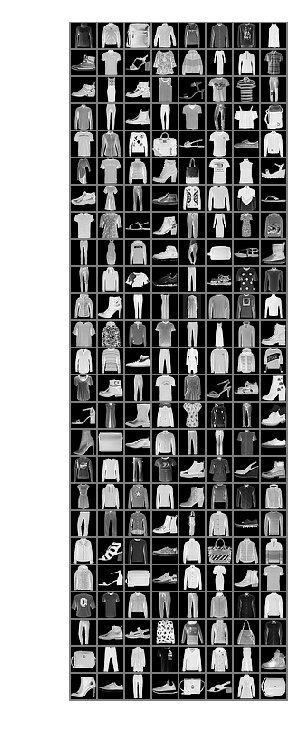

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

# Functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    
    figure(num=None, figsize=(8, 6), dpi=150, edgecolor='k')
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

##3.2.3 Create your Convolutional Neural Network
Create the CNN with layers as mentioned in the LaTeX pdf for full credit.  
You are, however, free to change the architecture as long as you achieve accuracy better than the architecture shown in the LaTeX pdf.



In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 5, 1, 2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
        self.dropout = nn.Dropout(p=0.5)
        self.fc = nn.Linear(1568, 10)


    def forward(self, x):

      p = F.relu(self.conv1(x))
      p = F.max_pool2d(p, 2, 2)
      
      p = F.relu(self.conv2(p))
      p = F.max_pool2d(p, 2, 2)
      
      p = self.dropout(p)
      p = p.view(-1, 1568)
      p = self.fc(p)
      
      return p

net = Net()

##3.2.4 Define a Loss function and optimizer
We will be using [Cross Entropy Loss](https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss) and [Adam optimizer](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam).  
Note: PyTorch's CrossEntropyLoss combines log softmax and negative log likelihood loss in one class. Make sure you are not computing softmax twice.



In [0]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-8)


##3.2.5. Train the network

Here we are going to train the network while logging the per batch metrics.  
This would take some time to run (5-10 minutes).



In [12]:
overall_step = 0


# number of epochs
epochs = 40


for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # Make predictions, calculate accuracy and update your weights once

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == labels).sum() / torch.tensor(200.0)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('Epoch: %d, Batch: %5d, loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0
            # Any thing that is added to the "info" gets plotted in tensorboard
            # Add the plots in Tensorboard to the report and explain what is happening
            info = { ('loss') : loss.item(),('accuracy'): accuracy.item()}
            for tag, value in info.items():
                logger.scalar_summary(tag, value, overall_step+1)
            overall_step = overall_step + 1

print('Finished Training')

Epoch: 1, Batch:   200, loss: 1.464
Epoch: 2, Batch:   200, loss: 0.704
Epoch: 3, Batch:   200, loss: 0.600
Epoch: 4, Batch:   200, loss: 0.542
Epoch: 5, Batch:   200, loss: 0.507
Epoch: 6, Batch:   200, loss: 0.477
Epoch: 7, Batch:   200, loss: 0.452
Epoch: 8, Batch:   200, loss: 0.441
Epoch: 9, Batch:   200, loss: 0.427
Epoch: 10, Batch:   200, loss: 0.420
Epoch: 11, Batch:   200, loss: 0.402
Epoch: 12, Batch:   200, loss: 0.396
Epoch: 13, Batch:   200, loss: 0.391
Epoch: 14, Batch:   200, loss: 0.388
Epoch: 15, Batch:   200, loss: 0.377
Epoch: 16, Batch:   200, loss: 0.368
Epoch: 17, Batch:   200, loss: 0.362
Epoch: 18, Batch:   200, loss: 0.361
Epoch: 19, Batch:   200, loss: 0.352
Epoch: 20, Batch:   200, loss: 0.349
Epoch: 21, Batch:   200, loss: 0.344
Epoch: 22, Batch:   200, loss: 0.339
Epoch: 23, Batch:   200, loss: 0.338
Epoch: 24, Batch:   200, loss: 0.331
Epoch: 25, Batch:   200, loss: 0.327
Epoch: 26, Batch:   200, loss: 0.327
Epoch: 27, Batch:   200, loss: 0.325
Epoch: 28,

##3.2.6 Test Accuracy
Let us look at how the network performs on the test dataset.  
Report your accuracy in your report.



In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Report this accuracy in your report.

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 88 %


##3.2.7 Per Class accuracy
Now we see the test accuracy for each class in the test dataset.  
Report these accuracies in your report. Also identify the problematic classes.  
Can you explain why these classes have significantly lower accuracies compared to other classes? Record your responses in your LaTeX file.


In [14]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 76 %
Accuracy of Trouser : 95 %
Accuracy of Pullover : 71 %
Accuracy of Dress : 85 %
Accuracy of  Coat : 95 %
Accuracy of Sandal : 93 %
Accuracy of Shirt : 66 %
Accuracy of Sneaker : 96 %
Accuracy of   Bag : 100 %
Accuracy of Ankle boot : 92 %
